### A close to paper implementation

#### I begin with the GPDriftFit
This is in my opinion the hardest to understand section of the paper, and the referenced work (Papaspiliopoulos et al; 2012) is also rather dense. Luckily appendix F.1 provides some clarification.

$$ 
[\tilde{\mathbf{u}}^+ (x,t)]_d = \mathrm{vec}(\mathbf{k}_d^+(x\oplus t))^T(\tilde{\mathbf{K}}_d^+ + \frac{\gamma}{\Delta t} \mathbb{I}_{MT})^{-1}\mathrm{vec}(\mathbf{Y^+_d}), \\
\\
[\tilde{\mathbf{u}}^- (x,t)]_d = \mathrm{vec}(\mathbf{k}_d^-(x\oplus t))^T(\tilde{\mathbf{K}}_d^- + \frac{\gamma}{\Delta t} \mathbb{I}_{NT})^{-1}\mathrm{vec}(\mathbf{Y^-_d}), \\
~\\
[\tilde{\mathbf{K}}^{\pm}_d]_{i\cdot T +l, i'\cdot T + l'} = [\mathbf{K}^{\pm}_d]_{ii'll'},\\
[\mathbf{K}^{+}_d]_{mm'll'} = K_d(\mathbf{x}_{t_l -\Delta t}^{(m)-}\oplus (t_l - \Delta t), \mathbf{x}_{t_{l'} -\Delta t}^{(m')-}\oplus (t_{l'} - \Delta t)), \\
[\mathbf{K}^{-}_d]_{nn'kk'} = K_d(\mathbf{x}^{(n)+}_{t_k} \oplus t_k, \mathbf{x}_{t_{k'}}^{(n')+}\oplus t_{k'}),\\
\\
[\mathbf{k}_d^+(\mathbf{x}\oplus t)]_{lm} = K_d(\mathbf{x} \oplus t,\mathbf{x}^{(m)-}_{t_l - \Delta t} \oplus (t_l - \Delta t)),
\\
[\mathbf{k}_d^-(\mathbf{x}\oplus t)]_{kn} = K_d(\mathbf{x}\oplus t, \mathbf{x}_{t_k}^{(n)-}\oplus (t_k)),
\\
[\mathbf{Y}_d^\pm]_{li} = \left[\frac{\pm\mathbf{x}^{(i)\mp}_{t_l} \mp \mathbf{x}^{(i)\mp}_{t_l - \Delta t}}{\Delta t} \right]_d
$$


##### Beginning with a kernel $K_d$

In [225]:
# RBF 
import numpy as np
# Note that sigma is needed for the kernel
sigma = 0.05
K = lambda x, xp: np.exp(-np.linalg.norm(x-xp)**2 / (2*sigma**2))

##### Next We Make $Y_d^\pm$
Assume for now that we work in 1d

In [ ]:
# Y operates on the finite difference of the forward/backwards path.
# Run on vertical data, with last time point at bottom, then each particle is a column
# .shape[0] gives the number of entries
def Y(series, times, dir='+'):
    dts = np.diff(times, axis=0)
    diffs = np.diff(series, axis=0)

    y_ds = diffs / dts

    return y_ds.flatten()


##### Make the $\mathbf{k_d}$ function

In [ ]:
class k:
    def __init__(self, series, times, kernel = K):
        self.series = series
        self.times = times
        self.kernel = kernel
    
    def klm(self, x,t,l,m):
        return self.kernel(np.asmatrix([x,t]), np.asmatrix([self.series[l,m], self.times[l,m]]))
    
    def evalm(self, x, t, dir='+'):
        k_vec = np.zeros(0)
        init = 1 if dir == '+' else 0  # skip first row for '+'; skip last row for '-'
        for m in range(self.series.shape[1]):
            for l in range(init, self.series.shape[0] - (1 - init)):
                k_vec = np.append(k_vec, self.klm(x, t, l, m, dir))
        return np.asmatrix(k_vec).T


##### Make the $\mathbf{K}$ function

In [ ]:
class K_tilde:
    def __init__(self, series, times, kernel=K):
        self.series = series
        self.times = times
        self.kernel = kernel

    def K_mmll(self, l, m, lp, mp, dir='+'):
        # Shift both directions to align with Y
        if dir == '+':
            l -= 1
            lp -= 1
        elif dir == '-':
            # For backward differences, we shift the "later" index
            # so that Y^- aligns with series[1:] properly
            pass  # l, lp unchanged; handled by init
        return self.kernel(
            np.asmatrix([self.series[l, m], self.times[l, m]]),
            np.asmatrix([self.series[lp, mp], self.times[lp, mp]])
        )

    def evalK(self, dir='+'):
        T = self.series.shape[0]
        N = self.series.shape[1]
        T_eff = T - 1

        size = T_eff * N
        Kmat = np.zeros((size, size))

        # offset to align with Y vector
        init = 1 if dir == '+' else 0

        for m in range(N):
            for l in range(T_eff):
                row = m * T_eff + l
                l_idx = l + init  # actual index into series

                for mp in range(N):
                    for lp in range(T_eff):
                        col = mp * T_eff + lp
                        lp_idx = lp + init  # actual index into series

                        Kmat[row, col] = self.K_mmll(l_idx, m, lp_idx, mp, dir)

        return Kmat


##### Implement u


In [ ]:
def predict(x, t, dir, series, times, kernel = K, gamma = 0.1, deltaT = 0.1):
    k_gen = k(series, times, kernel)
    K_gen = K_tilde(series, times, kernel)

    k_vec = k_gen.evalm(x,t, dir)
    K_til = K_gen.evalK(dir)
    Y_vec = Y(series, times, dir)
    I = np.identity(K_til.shape[0])
    #print(k_vec)
    #print(K_til)
    #print(I)
    #print(Y_vec)

    mean = k_vec.T*np.linalg.inv(K_til + (gamma/deltaT)*I)*Y_vec
    return mean
    
def predictor(dir, series, times, kernel = K, gamma = 1, deltaT = 0.1):
    k_gen = k(series, times, kernel)
    K_gen = K_tilde(series, times, kernel)

    K_til = K_gen.evalK(dir)
    Y_vec = Y(series, times, dir)
    I = np.identity(K_til.shape[0])

    tail = np.linalg.inv(K_til + (gamma/deltaT)*I)*Y_vec

    return lambda x, t: (k_gen.evalm(x,t, dir).T*tail).item()

##### Test the prediction routine

In [ ]:
series = np.asmatrix([[0, 2, 4, 5, 6],[2,4,5,6,7]]).T
times = np.asmatrix([[0, 1, 2, 3, 4],[0,1,2,3,4]]).T
deltaT = 1
predict(2,1,'+',series=series, times=times, kernel=K, deltaT=deltaT)

ValueError: shapes (1,2) and (0,0) not aligned: 2 (dim 1) != 0 (dim 0)

### Create a dummy bridge to learn

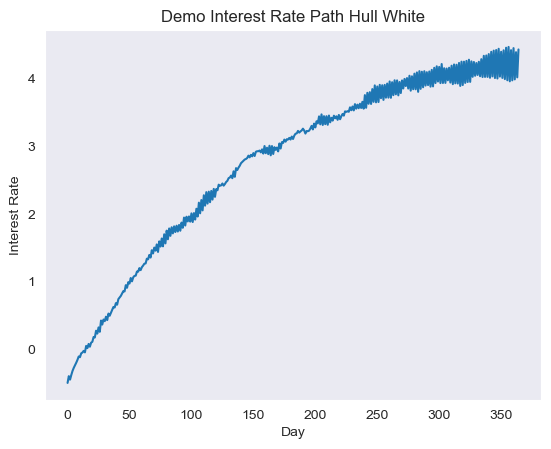

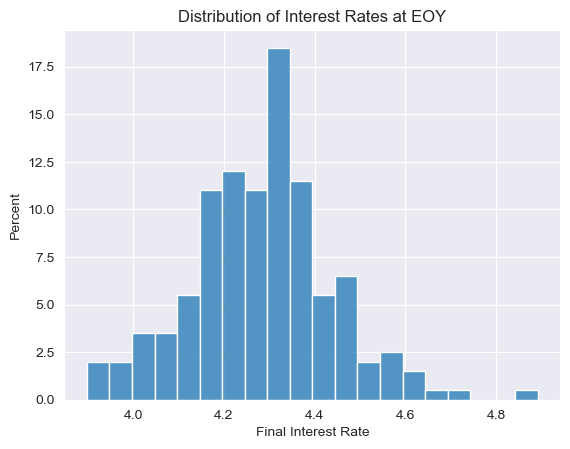

In [145]:
from numpy.random import normal as normal
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from random import choices as draw
from itertools import chain

## Hull White Model
theta = 5 # Stasis rate 500%
alpha = 4 # Juiced Return Rate
sigma = 0.05*np.sqrt(100)
dt = 1/365 # Daily updates

hw = lambda r: r + alpha*(theta - r)*dt + sigma*np.sqrt(dt)*normal()
r0 = -0.5 # Initial interest rate of -50% means that we will see an expected drift up

rs = [r0]
for i in range(364):
    rs.append(hw(rs[i-1]))

plt.plot(rs)
plt.title('Demo Interest Rate Path Hull White')
plt.ylabel('Interest Rate')
plt.xlabel('Day')
plt.grid()
plt.show()

## Generate 200 paths for an empirical set of end points
def generatePath():
    rs = [normal(r0, sigma**2)]
    for i in range(364):
        rs.append(hw(rs[i-1]))
    return rs

paths = [generatePath() for i in range(200)]
end_data = [path[-1] for path in paths]
start_data = [path[0] for path in paths]
sb.histplot(end_data, bins = 20, stat = 'percent');
plt.xlabel('Final Interest Rate');
plt.title('Distribution of Interest Rates at EOY');
plt.show()

In [202]:
## Now we Drop The Pathwise info completely, and keep only the edges
paths.clear()
frames = {'start': start_data, 'end': end_data}

## And fit the Schrodinger Bridge by iterated MLE, using the GPDriftFit
numSamples = 20
schrodSteps = 10
N = 10
T = 1

def solveSDE(x0s, t0 = 0, T = T, func = lambda x,t: 0, steps = N, sigma = sigma):
    deltaT = (T-t0)/steps
    times = np.arange(t0,T+deltaT,deltaT)
    x_list = []
    for x0 in x0s:
        xs = [x0]
        for i in np.arange(1,steps+1):
            xs.append(xs[i-1] + deltaT*func(xs[i-1],times[i-1]) + sigma*np.sqrt(np.abs(deltaT))*normal())
        x_list.append(xs)
    return x_list, [times for x in x0s]

forwardFunc = lambda x,t: 0

for i in range(1,schrodSteps+1):
    forwardPaths, forwardTimes = solveSDE(draw(frames['start'],k=numSamples), func = forwardFunc, dir = '+')
    forwardPaths = np.asmatrix(forwardPaths).T
    forwardTimes = np.asmatrix(forwardTimes).T

    backwardFunc = predictor('-', forwardPaths, forwardTimes, deltaT=T/N, gamma=0.005)
    backwardsPaths, backwardsTimes = solveSDE(draw(frames['end'],k=numSamples), func = backwardFunc, dir = '-')
    backwardsPaths = np.asmatrix(backwardsPaths).T
    backwardsTimes = np.asmatrix(backwardsTimes).T

    forwardFunc = predictor('+', backwardsPaths, backwardsTimes, deltaT=T/N, gamma=0.005)

    print(i)

TypeError: solveSDE() got an unexpected keyword argument 'dir'

In [203]:
def shareax(ax1,ax2):
    ax1.sharex(ax2)
    #ax1.sharey(ax2)
    ax1.relim()
    ax1.autoscale_view()
    ax1.label_outer()
    ax2.label_outer()

fdummies, _ = solveSDE(draw(frames['start'],k=10), t0 = 0, T = 1, steps = 10, func = forwardFunc)
f_final = [d[-1] for d in fdummies]
bdummies, _ = solveSDE(draw(frames['end'],k=10), t0 = 0, T = 1, steps = 10, func = backwardFunc, dir = '-')
d_initial = [d[-1] for d in bdummies]

fig, axes = plt.subplots(2,2,figsize = (12,8))
fig.set_layout_engine('tight')
sb.set_style("darkgrid")
sb.kdeplot({'Generated': f_final,'Observed':end_data}, ax=axes[0,0], fill=True, common_norm=False);
sb.ecdfplot({'Generated': f_final,'Observed':end_data}, ax = axes[1,0])
sb.kdeplot({'Generated': d_initial,'Observed':frames['start']}, ax=axes[0,1],fill=True, common_norm=False,);
sb.ecdfplot({'Generated': d_initial,'Observed':frames['start']}, ax = axes[1,1])
fig.supxlabel('Final Interest Rate');
fig.suptitle('Interest Rate, Generated by Bridge from IV/FV vs Observed')
shareax(axes[0,0],axes[1,0])
shareax(axes[1,1],axes[0,1])
axes[0,0].set_title('Forward / Final from Initial');
axes[0,1].set_title('Backwards / Initial from Final');
plt.show()


TypeError: solveSDE() got an unexpected keyword argument 'dir'

In [224]:
## Test The Combo of solvePDE and DriftFit
constDrift = lambda x, y: y
rconstDrift = lambda x, y: y

## Generate constant growth paths
const_fwd, fwd_times = solveSDE([1], func=rconstDrift, steps = 10, t0 = 1, T = 0, sigma=0)
const_fwd = np.asmatrix(const_fwd).T
fwd_times = np.asmatrix(fwd_times).T

print(const_fwd)
print(fwd_times)
## Fit 
pred = predictor('+', const_fwd, fwd_times, gamma=0.0001, deltaT = 0.1)
print(pred(.46, 0.1))
#plt.scatter(fwd_times, const_fwd)


[[1.  ]
 [0.9 ]
 [0.81]
 [0.73]
 [0.66]
 [0.6 ]
 [0.55]
 [0.51]
 [0.48]
 [0.46]
 [0.45]]
[[1.00000000e+00]
 [9.00000000e-01]
 [8.00000000e-01]
 [7.00000000e-01]
 [6.00000000e-01]
 [5.00000000e-01]
 [4.00000000e-01]
 [3.00000000e-01]
 [2.00000000e-01]
 [1.00000000e-01]
 [2.22044605e-16]]
0.10197460691312443
